In [98]:
# Import needed files and basic setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import data_gen2
import tropical

from ipywidgets import Output
from IPython.display import display, Markdown, Latex, Math, clear_output

from sklearn import neighbors

import math

from cvxopt import solvers, matrix

import time

import scipy

from sklearn.decomposition import PCA

%matplotlib notebook
#plt.ion()

In [5]:
# Hyperparameters
n_epochs = 100
batch_size_train = 16
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [6]:
# Load training and testing sets
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [112]:
npzfile = np.load('parameters.npz')

A1 = npzfile['A1']
b1 = npzfile['b1']
A2 = npzfile['A2']
b2 = npzfile['b2']

8559.193676710129


<IPython.core.display.Javascript object>


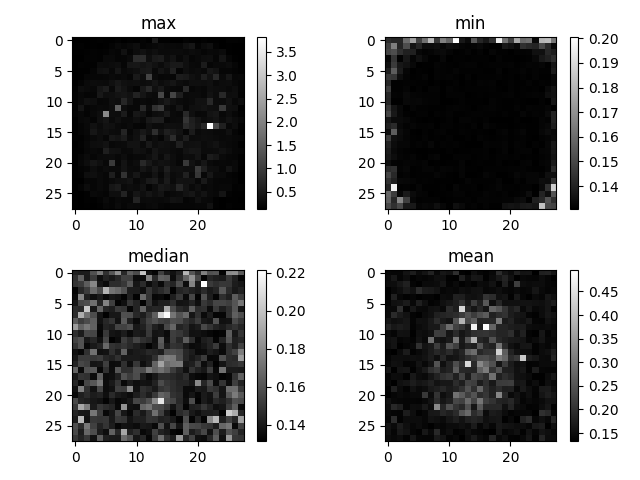

In [72]:
sizes = np.zeros((0, 784))
i = 0
start = time.time()
for data, _ in train_loader:
    data = data.numpy().reshape(-1, 784)
    for sample_idx in range(data.shape[0]):
        size = np.zeros((1, 784))
        for dim_idx in range(data.shape[1]):
            tmp = np.divide(-b1 - data[sample_idx, dim_idx]*A1[:, dim_idx], A1[:, dim_idx])
            # (x + eps)*w + b = 0, eps > 0
            # (x - eps)*w + b = 0, eps > 0
            size[0, dim_idx]  = np.amin(tmp[tmp >= 0]) + np.amin(-tmp[tmp <= 0])
        sizes = np.vstack((sizes, size))
        i += 1
print(time.time() - start)

# Rescale to 0-1 scale
sizes = sizes*0.3081 + 0.1307

maxs = np.amax(sizes, axis=0)
maxs = maxs.reshape(28, 28)

mins = np.amin(sizes, axis=0)
mins = mins.reshape(28, 28)

medians = np.median(sizes, axis=0)
medians = medians.reshape(28, 28)

means = np.mean(sizes, axis=0)
means = means.reshape(28, 28)


fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

im = ax1.imshow(maxs, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax1)
im = ax2.imshow(mins, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax2)
im = ax3.imshow(medians, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax3)
im = ax4.imshow(means, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax4)

ax1.set_title('max')
ax2.set_title('min')
ax3.set_title('median')
ax4.set_title('mean')

plt.tight_layout()

In [92]:
npzfile = np.load('binaryFeatures.npz')

binaryFeatures = npzfile['binaryFeatures']
targets = npzfile['targets']

In [93]:
print(binaryFeatures.shape)

(60000, 128)


In [125]:
def calcLinRegions(classToConsider, outputToConsider):
    binaryFeaturesTemp = binaryFeatures[targets.ravel() == classToConsider, :]
    linRegions = np.zeros((0, 784))
    for sample_idx in range(binaryFeaturesTemp.shape[0]):
        A = A1[binaryFeaturesTemp[sample_idx, :], :]
        B = A2[outputToConsider, binaryFeaturesTemp[sample_idx, :]]
        linRegions = np.vstack((linRegions, np.matmul(B, A)))
    return linRegions
        
def plotLinRegions(linRegions):
    maxs = np.amax(linRegions, axis=0)
    maxs = maxs.reshape(28, 28)

    mins = np.amin(linRegions, axis=0)
    mins = mins.reshape(28, 28)

    medians = np.median(linRegions, axis=0)
    medians = medians.reshape(28, 28)

    means = np.mean(linRegions, axis=0)
    means = means.reshape(28, 28)


    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    im = ax1.imshow(maxs, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
    fig.colorbar(im, ax=ax1)
    im = ax2.imshow(mins, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
    fig.colorbar(im, ax=ax2)
    im = ax3.imshow(medians, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
    fig.colorbar(im, ax=ax3)
    im = ax4.imshow(means, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
    fig.colorbar(im, ax=ax4)

    ax1.set_title('max')
    ax2.set_title('min')
    ax3.set_title('median')
    ax4.set_title('mean')

    plt.tight_layout()

<IPython.core.display.Javascript object>


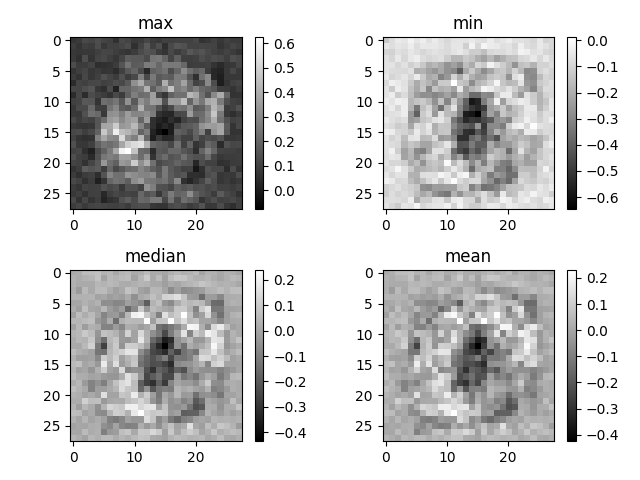

<IPython.core.display.Javascript object>


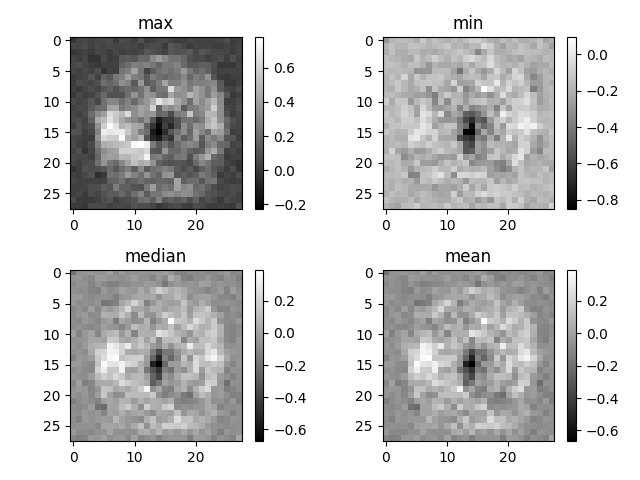

<IPython.core.display.Javascript object>


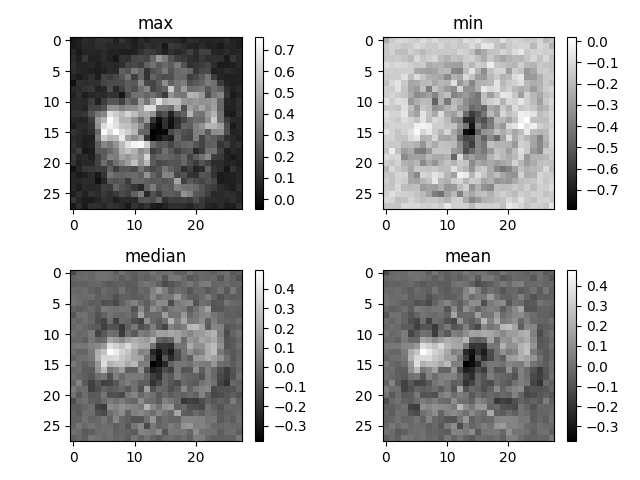

<IPython.core.display.Javascript object>


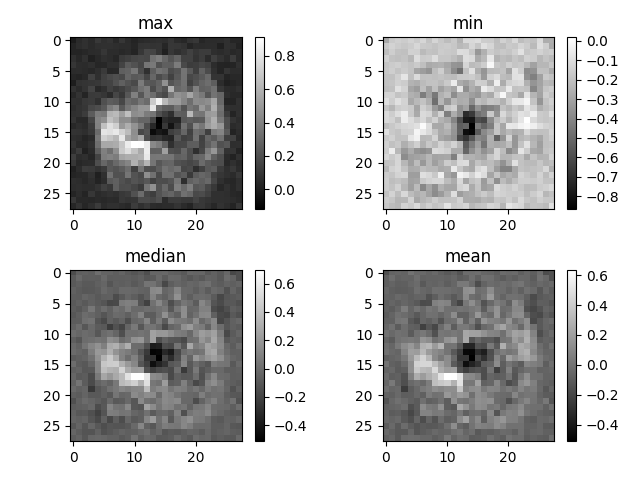

<IPython.core.display.Javascript object>


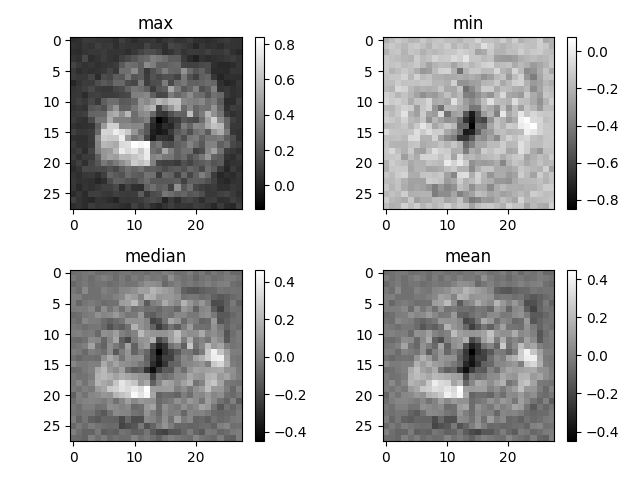

<IPython.core.display.Javascript object>


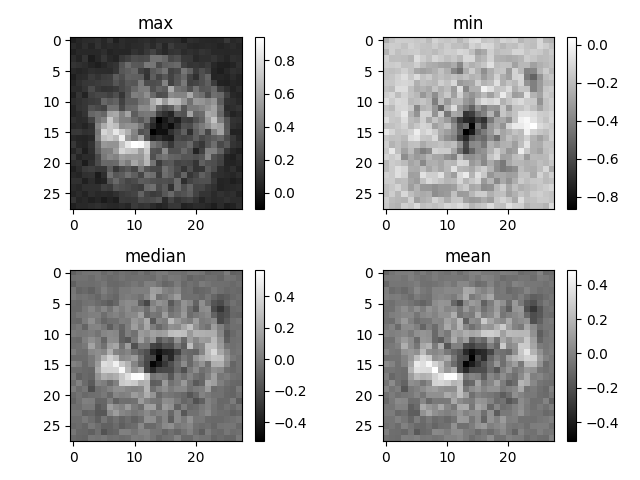

<IPython.core.display.Javascript object>


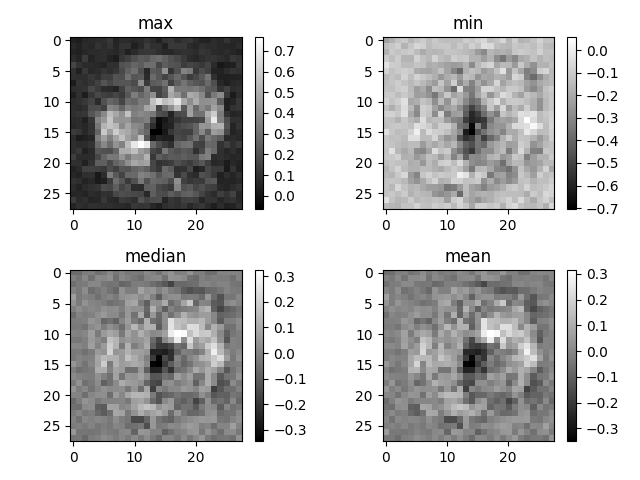

<IPython.core.display.Javascript object>


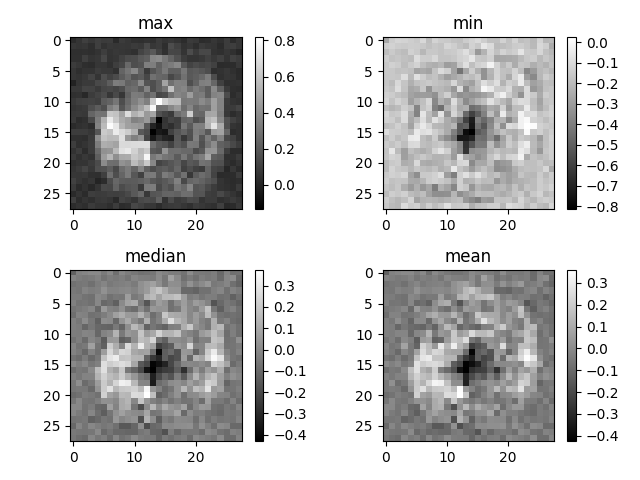

<IPython.core.display.Javascript object>


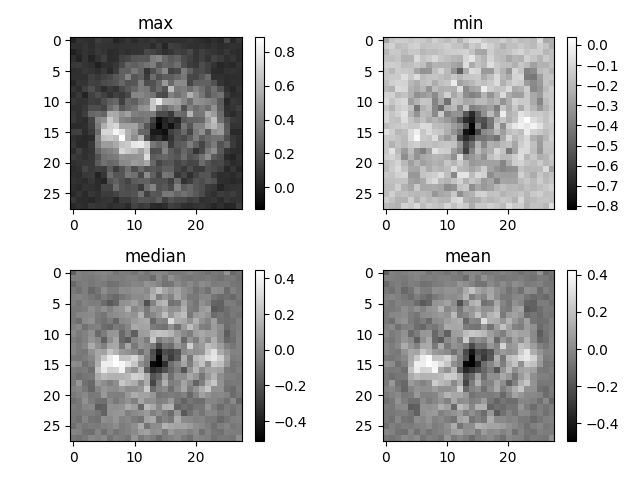

<IPython.core.display.Javascript object>


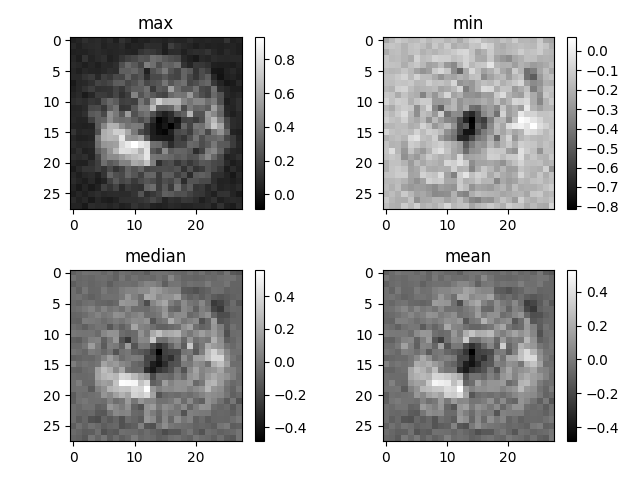

In [128]:
for i in range(10):
    linRegions = calcLinRegions(i, 0)
    plotLinRegions(linRegions)

In [107]:
binaryFeaturesZero = binaryFeatures[targets.ravel() == 0, :]

In [114]:
linRegions = np.zeros((0, 784))
for sample_idx in range(binaryFeaturesZero.shape[0]):
    A = A1[binaryFeaturesZero[sample_idx, :], :]
    B = A2[0, binaryFeaturesZero[sample_idx, :]]
    linRegions = np.vstack((linRegions, np.matmul(B, A)))

<IPython.core.display.Javascript object>


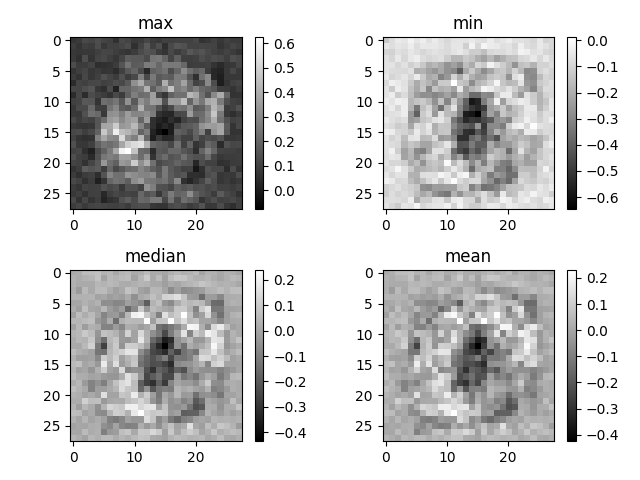

In [115]:
maxs = np.amax(linRegions, axis=0)
maxs = maxs.reshape(28, 28)

mins = np.amin(linRegions, axis=0)
mins = mins.reshape(28, 28)

medians = np.median(linRegions, axis=0)
medians = medians.reshape(28, 28)

means = np.mean(linRegions, axis=0)
means = means.reshape(28, 28)


fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

im = ax1.imshow(maxs, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax1)
im = ax2.imshow(mins, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax2)
im = ax3.imshow(medians, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax3)
im = ax4.imshow(means, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax4)

ax1.set_title('max')
ax2.set_title('min')
ax3.set_title('median')
ax4.set_title('mean')

plt.tight_layout()

<IPython.core.display.Javascript object>


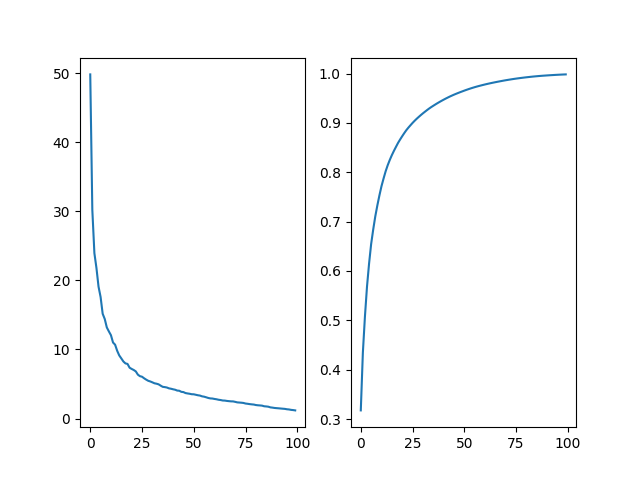

In [110]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
pika = PCA()
pika.fit(linRegions)
ax1.plot(pika.singular_values_[:100])
ax2.plot(np.cumsum(pika.explained_variance_ratio_[:100]))

<IPython.core.display.Javascript object>


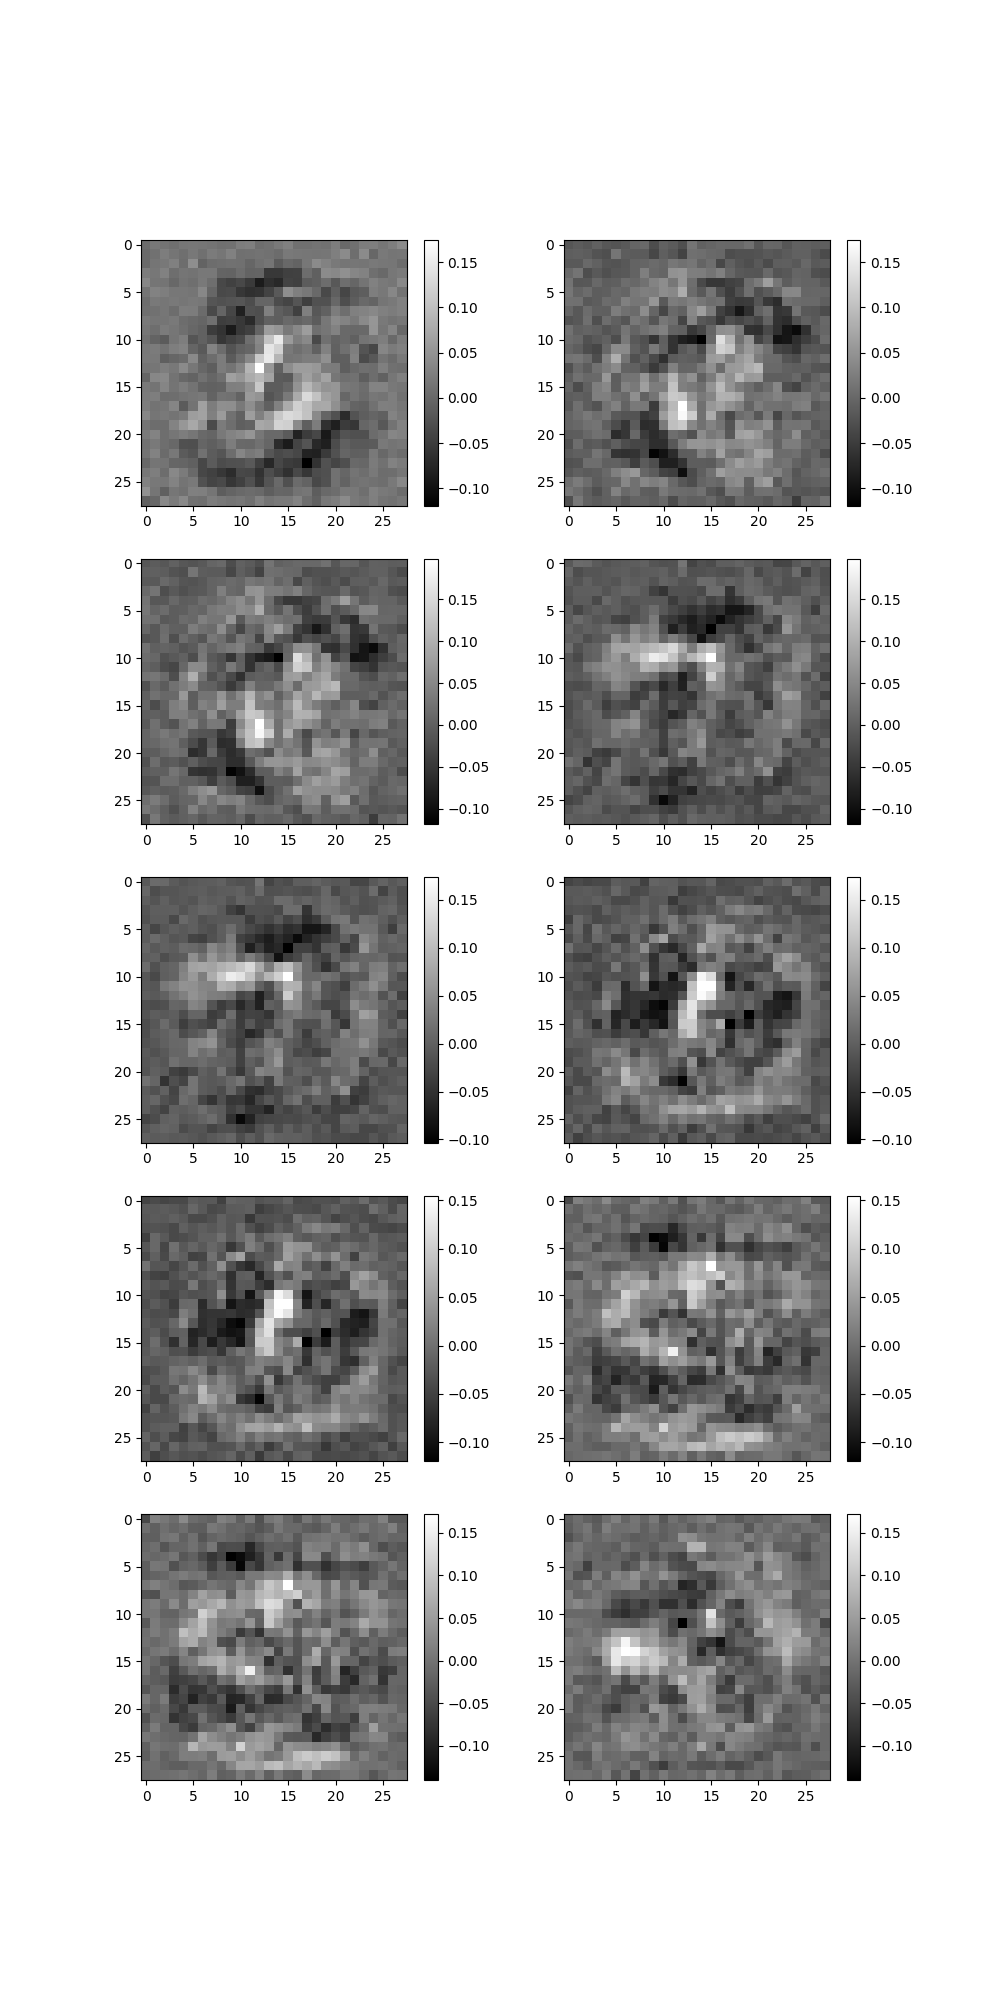

In [111]:
fig = plt.figure(figsize=(10, 20))

for i in range(5):
    ax1 = fig.add_subplot(5, 2, 2*i+1)
    ax2 = fig.add_subplot(5, 2, 2*i+2)
    im = ax1.imshow(pika.components_[i, :].reshape(28, 28), cmap='gray', interpolation='none')#, vmin=0, vmax=255)
    im = ax2.imshow(pika.components_[i+1, :].reshape(28, 28), cmap='gray', interpolation='none')#, vmin=0, vmax=255)
    fig.colorbar(im, ax=ax1)
    fig.colorbar(im, ax=ax2)

In [116]:
binaryFeaturesEight = binaryFeatures[targets.ravel() == 8, :]

In [117]:
linRegions = np.zeros((0, 784))
for sample_idx in range(binaryFeaturesEight.shape[0]):
    A = A1[binaryFeaturesEight[sample_idx, :], :]
    B = A2[8, binaryFeaturesEight[sample_idx, :]]
    linRegions = np.vstack((linRegions, np.matmul(B, A)))

<IPython.core.display.Javascript object>


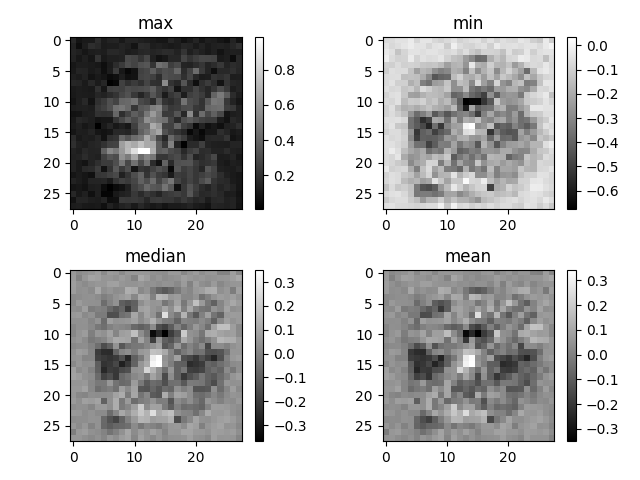

In [118]:
maxs = np.amax(linRegions, axis=0)
maxs = maxs.reshape(28, 28)

mins = np.amin(linRegions, axis=0)
mins = mins.reshape(28, 28)

medians = np.median(linRegions, axis=0)
medians = medians.reshape(28, 28)

means = np.mean(linRegions, axis=0)
means = means.reshape(28, 28)


fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

im = ax1.imshow(maxs, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax1)
im = ax2.imshow(mins, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax2)
im = ax3.imshow(medians, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax3)
im = ax4.imshow(means, cmap='gray', interpolation='none')#, vmin=0, vmax=255)
fig.colorbar(im, ax=ax4)

ax1.set_title('max')
ax2.set_title('min')
ax3.set_title('median')
ax4.set_title('mean')

plt.tight_layout()

<IPython.core.display.Javascript object>


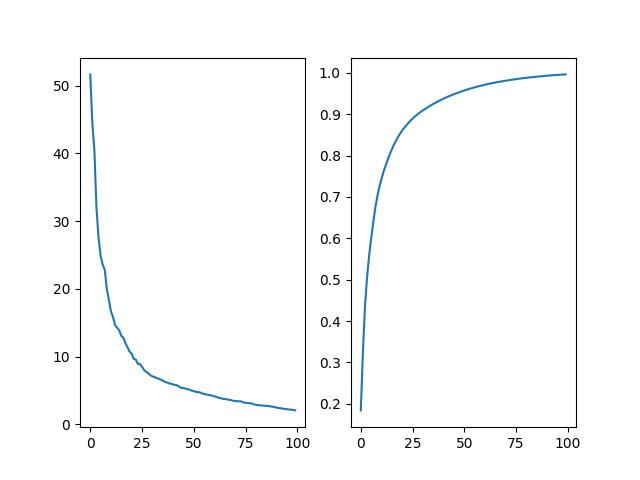

In [120]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
pika = PCA()
pika.fit(linRegions)
ax1.plot(pika.singular_values_[:100])
ax2.plot(np.cumsum(pika.explained_variance_ratio_[:100]))

<IPython.core.display.Javascript object>


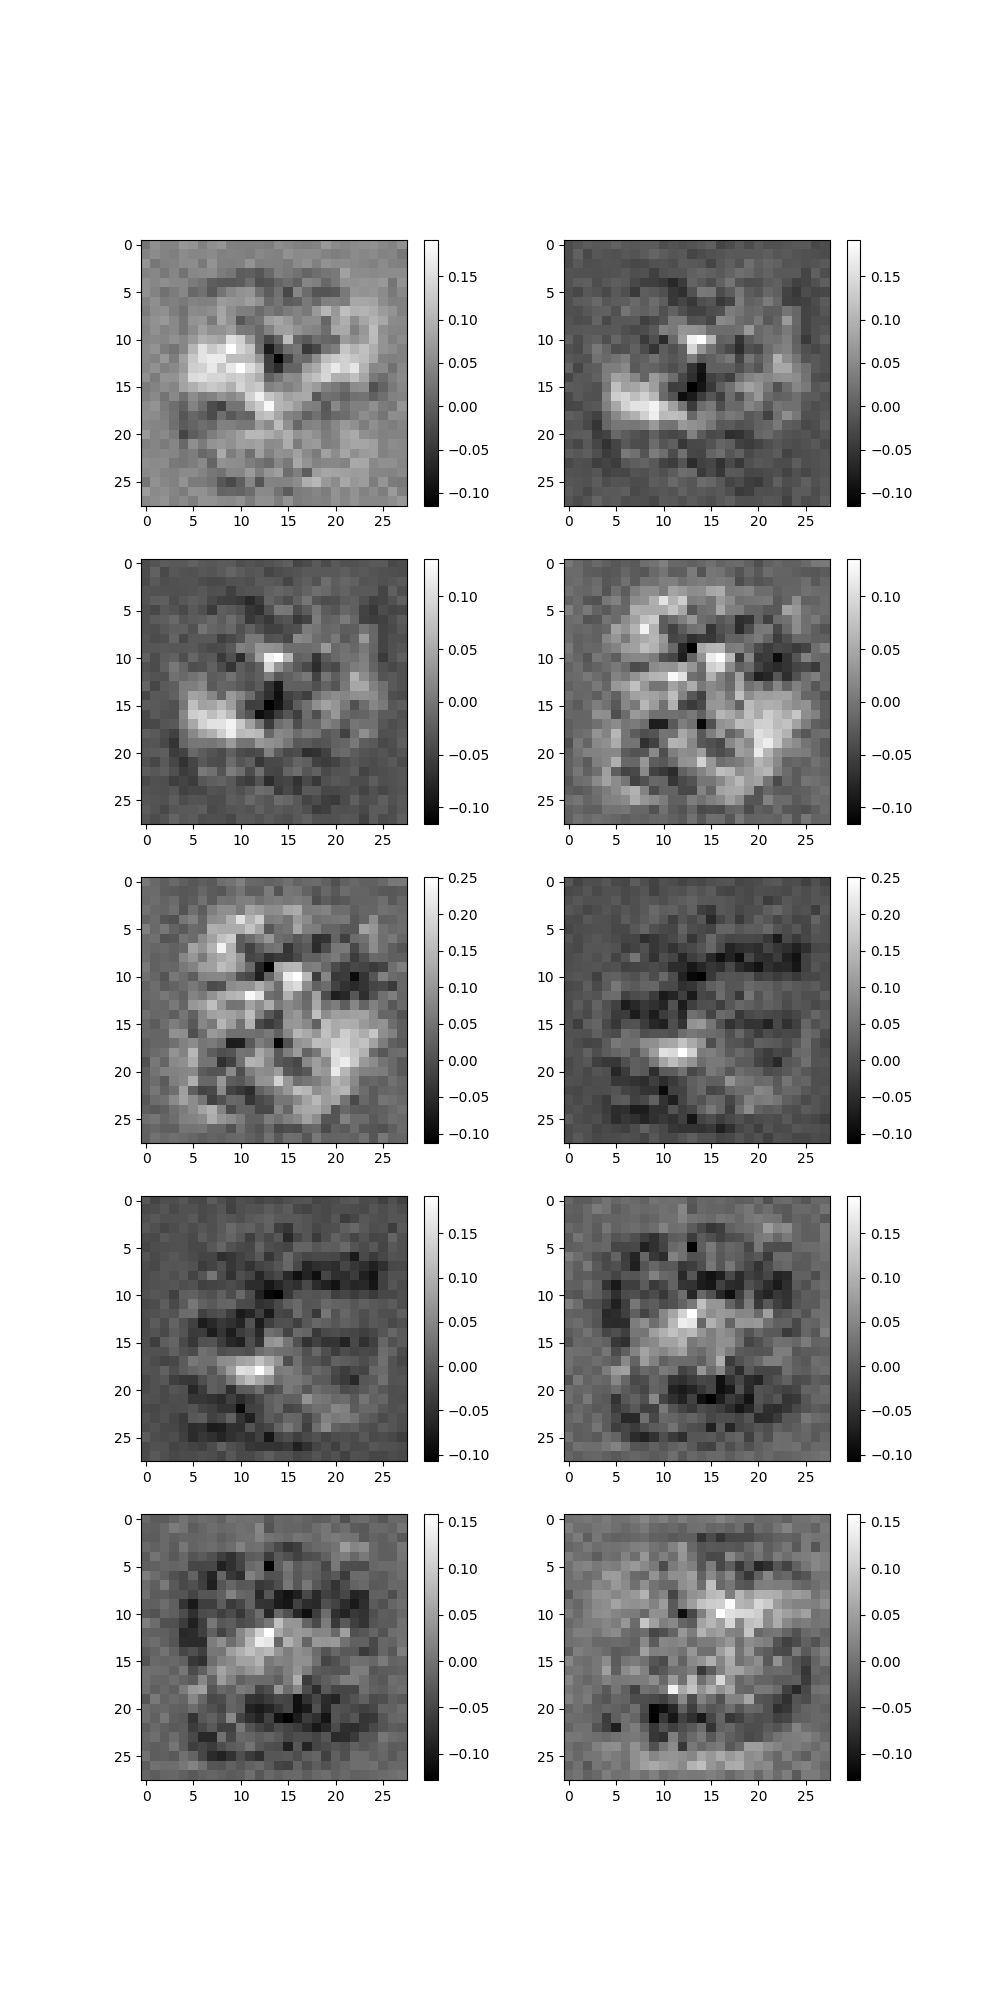

In [121]:
fig = plt.figure(figsize=(10, 20))

for i in range(5):
    ax1 = fig.add_subplot(5, 2, 2*i+1)
    ax2 = fig.add_subplot(5, 2, 2*i+2)
    im = ax1.imshow(pika.components_[i, :].reshape(28, 28), cmap='gray', interpolation='none')#, vmin=0, vmax=255)
    im = ax2.imshow(pika.components_[i+1, :].reshape(28, 28), cmap='gray', interpolation='none')#, vmin=0, vmax=255)
    fig.colorbar(im, ax=ax1)
    fig.colorbar(im, ax=ax2)